In [1]:
from gurobipy import *

## 本研究

In [2]:
def CVaR(ship_num,stack_num,height,n_init,size,size_,beta,mean,cov,OC): 
  O1=[i+1 for i in range(ship_num)]
  S=[i+1 for i in range(stack_num)]
  H=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]
  f=stack_num*height-sum(n_init)

  from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
  import random
  from random import seed
  import numpy as np
  from scipy.stats import multivariate_normal

  # 期待値と分散共分散行列の準備
  data_1 = np.random.multivariate_normal(mean, cov, size=size)

  O_=np.argsort(data_1)
  O_=O_+np.ones((size,ship_num)).astype(int)
  global O
  O=O_.tolist()
  m=Model("CVaR")

  alpha=m.addVar(vtype="C")

  # 変数の定義
  x,c,d={},{},{}
  for s in S:
    for h in H:
      for p in P:
        x[s,h,p]=m.addVar(vtype="B")

  for s in S:
    for h in range(2,len(H)+1):
      for i,o in enumerate(O):
        c[s,h,i]=m.addVar(vtype="c",lb=0)

  for i in range(len(O)):
    d[i]=m.addVar(vtype="C",lb=0)

  for p in P:
    m.addConstr(quicksum(x[s,h,p] for s in S for h in H)==n_init[p-1])

  for s in S:
    for h in H:
      m.addConstr(quicksum(x[s,h,p] for p in P)<=1)

  for s in S:
    for h in range(1,len(H)):
      m.addConstr(quicksum(x[s,h+1,p] for p in P)<=quicksum(x[s,h,p] for p in P))

  for s in S:
    for h in range(2,len(H)+1):
      for h_ in range(1,h):
        for i,o in enumerate(OC):
          for j,p in enumerate(o):
            m.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

  for i in range(len(OC)):
    m.addConstr(d[i]>=quicksum(c[s,h,i] for s in S for h in H if h!=1)-alpha)


  m.setObjective(alpha+quicksum(d[i] for i in range(len(O)))/((1-beta)*len(O)))

  if f>=height:
    m.optimize()
  else:
    print("f<h")
  # m.optimize()

  print("================================================")

  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:

    global result
    result=np.zeros((height,stack_num))
    for (s,h,p) in x:
      if x[s,h,p].X>EPS:
        result[height-h][s-1]=int(p)

    result=result.astype(int)
    # print("VaR=",alpha.X)
    # print("the objective function", m.objVal)
    global LB
    LB=m.objVal
    # print(result)

    global penalty
    penalty=[]
    for k in O:
      OO=k
      a=0
      for j in range(stack_num):
          for i in range(1,height):
              for i_ in range(i+1,height+1):
                  if result[i-1][j]!=0 and result[i_-1][j]!=0:
                      if OO.index(result[i-1][j])>OO.index(result[i_-1][j]):
                          # print(j+1,height-i+1,O)
                          a+=1
                          # print("penalty!")
                              # print(i,i_,j+1,O)
                          break
      penalty.append(a)
      # print(a)
    penalty=np.sort(penalty)
    # print(penalty)

    # penalty=penalty[round(0.8*size):]
    # print(penalty)

In [3]:
def robust(ship_num,stack_num,height,n,Gamma,size,size_,mean,cov):
    # nと初期配置を変更しなければいけない
    num=sum(n)

    import numpy as np

    O1=[i+1 for i in range(ship_num)]

    Q=[i+1 for i in range(stack_num)]
    L=[i+1 for i in range(height)]
    P=[i+1 for i in range(ship_num)]
    I=[i+1 for i in range(num)]
    f=stack_num*height-len(I)
    a=1
    gamma=[]
    for i in n:
        for j in range(1,i+1):
            gamma.append(a)
        a+=1
    
    m=Model("BI")

    # 変数の定義
    alpha,beta={},{}
    for i in I:
        for q in Q:
            alpha[i,q]=m.addVar(vtype="B")
            beta[i,q]=m.addVar(vtype="B")
    J=[]
    for i in I:
        J.append([])
        for j in I:
            if gamma[i-1]<gamma[j-1]:
                if gamma[j-1]-gamma[i-1]<=Gamma:
                    J[i-1].append(j)

    for q in Q:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for i in I)<=len(L))

    for i in I:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for q in Q)==1)

    for i in I:
        for j in J[i-1]:
            for q in Q:
                m.addConstr(alpha[i,q]+alpha[j,q]+beta[j,q]<=1)

    m.setObjective(quicksum(beta[i,q] for i in I for q in Q))

    if f>=height:
        m.optimize()

    EPS=1.e-6

    if m.Status == GRB.OPTIMAL:
        print("====================================================")

        EPS=1.e-6
        a=[]
        for q in Q:
            a.append([])
        for (i,q) in alpha:
            if alpha[i,q].X>EPS:
                a[q-1].append(gamma[i-1])
        
        for (i,q) in beta:
            if beta[i,q].X>EPS:
                a[q-1].append(gamma[i-1])

        for q in Q:
            a[q-1]=sorted(a[q-1],reverse=True)

        global result_r
        result_r=np.zeros((height,stack_num))
        for q in Q:
            for i,r in enumerate(a[q-1]):
                result_r[height-i-1][q-1]=r
            # print(i,r)

        result_r=result_r.astype(int)
        
        print(result_r)
        print("the objective function", m.objVal)

        from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
        import random
        from random import seed
        import numpy as np
        from scipy.stats import multivariate_normal

        np.random.seed()
        data_1 = np.random.multivariate_normal(mean, cov, size=size_)

        O_=np.argsort(data_1)
        O_=O_+np.ones((size_,ship_num)).astype(int)
        OR=O_.tolist()


        global penalty_r
        penalty_r=[]
        for k in OR:
            O=k
            a=0
            for j in range(stack_num):
                for i in range(1,height):
                    for i_ in range(i+1,height+1):
                        if result_r[i-1][j]!=0 and result_r[i_-1][j]!=0:
                            if O.index(result_r[i-1][j])>O.index(result_r[i_-1][j]):
                                a+=1
                                # if Gamma ==2:
                                  # print(j+1,height-i+1,O)
                                # print("penalty!")
                                # print(i,i_,j+1,O)
                                break
            penalty_r.append(a)
        
        penalty_r=np.sort(penalty_r)
        penalty_r=penalty_r[round(0.75*size_):]
        # print(penalty_r)

        # import matplotlib.pyplot as plt
        # plt.boxplot(penalty_r)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 34 rows, 26097 columns and 336 nonzeros
Model fingerprint: 0x994f0a55
Variable types: 26001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 290

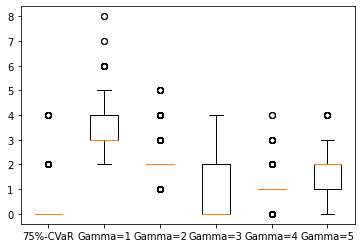

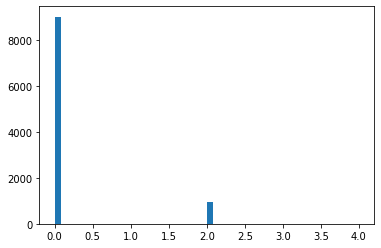

In [4]:
size=2000
size_=10000
beta=0.75
inst=[4,4,[2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
# mean=np.arange(1,ship_num+1)
mean=np.array([0.8,1,3,3.2,3.5,5.5])
covl=[2 for i in range(ship_num)]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=covl[1]
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0
OC=[]
EPS=0.1
a=0
UB=1000
LB=0
UB_k=[]
while UB-LB>=EPS and a<10:
    CVaR(len(inst[2]),inst[0],inst[1],inst[2],size,size_,beta,mean,cov,OC)
    n=0
    while n<beta*size:
        n+=1
    tau=n
    alpha_=penalty[tau-1]

    UB=((tau/size-beta)*alpha_+sum(penalty[tau:]))
    UB_k.append(UB)
    UB=min(UB_k)
    for b in range(round(size*0.1*a),round(size*0.1*(a+1))):
        OC.append(O[b])
    a+=1
    # print(OC)
print("finish!!")

data_2 = np.random.multivariate_normal(mean, cov, size=size_)

OR_=np.argsort(data_2)
OR_=OR_+np.ones((size_,ship_num)).astype(int)
OR=OR_.tolist()
penalty_cvar=[]
for k in OR:
    OR2=k
    a=0
    for j in range(inst[0]):
        for i in range(1,inst[1]):
            for i_ in range(i+1,inst[1]+1):
                if result[i-1][j]!=0 and result[i_-1][j]!=0:
                    if OR2.index(result[i-1][j])>OR2.index(result[i_-1][j]):
                        # print(j+1,height-i+1,O)
                        a+=1
                        # print("penalty!")
                            # print(i,i_,j+1,O)
                        break
    penalty_cvar.append(a)
penalty_cvar=np.sort(penalty_cvar)
pcvar=[]
pcvar+=list(penalty_cvar)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()
plt.hist(penalty_cvar,bins=50)
plt.show()

In [18]:
OC=[]
a=0
while a<10:
    for b in range(round(size*0.1*a),round(size*0.1*(a+1))):
        OC.append(O[b])
    print(len(OC),a)
    a+=1
    # len(O)

200 0
400 1
600 2
800 3
1000 4
1200 5
1400 6
1600 7
1800 8
2000 9


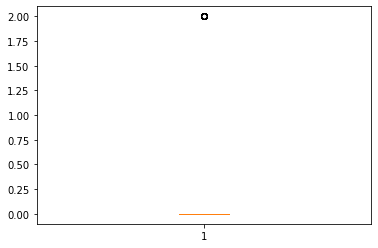

In [11]:
data_2 = np.random.multivariate_normal(mean, cov, size=size_)

OR_=np.argsort(data_2)
OR_=OR_+np.ones((size_,ship_num)).astype(int)
OR=OR_.tolist()
penalty_cvar=[]
for k in OR:
    OR2=k
    a=0
    for j in range(inst[0]):
        for i in range(1,inst[1]):
            for i_ in range(i+1,inst[1]+1):
                if result[i-1][j]!=0 and result[i_-1][j]!=0:
                    if OR2.index(result[i-1][j])>OR2.index(result[i_-1][j]):
                        # print(j+1,height-i+1,O)
                        a+=1
                        # print("penalty!")
                            # print(i,i_,j+1,O)
                        break
    penalty_cvar.append(a)
penalty_cvar=np.sort(penalty_cvar)
import matplotlib.pyplot as plt
penalty_cvar=penalty_cvar[round(0.75*size_):]
# plt.hist(penalty_cvar,bins=50)
plt.boxplot(penalty_cvar)
plt.show()

## 平均ベクトルを変える

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 145034 rows, 13097 columns and 1166336 nonzeros
Model fingerprint: 0x69a2e8c1
Variable types: 13001 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 117450 rows and 10530 columns (presolve time = 5s) ...
Presolve removed 117450 rows and 10530 columns
Presolve time: 6.29s
Presolved: 27584 rows, 2567 columns, 221876 nonzeros
Variable types: 2471 continuous, 96 integer (96 binary)
Found heuristic solution: objective 6.3280000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          7s
     525   -0.0000000e+00   0.000000e+00   0.000000e+00      7s
     525   -0.0000000e+00   0.000000e+00   

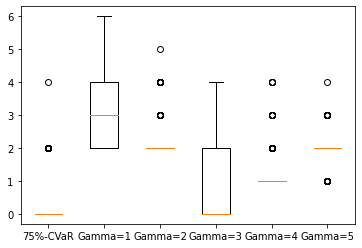

In [46]:
size=1000
size_=2000
loc=5
scale=0.5
inst=[4,4,[2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.array([1,1.5,4,5,7,7.5])
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
np.random.seed(0)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,loc,scale,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,loc,scale,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

## 5×4

#### 分散1

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 84442 rows, 6541 columns and 763290 nonzeros
Model fingerprint: 0x77d4a972
Variable types: 6401 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 53172 rows and 4032 columns
Presolve time: 4.11s
Presolved: 31270 rows, 2509 columns, 282726 nonzeros
Variable types: 2369 continuous, 140 integer (140 binary)
Found heuristic solution: objective 7.2200000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          5s
     521   -0.0000000e+00   0.000000e+00   0.000000e+00      5s
     521   -0.0000000e+00   0.000000e+00   0.000000e+00      5s
     521    0.0000000e+00   0.000000e+00   0.000000e+

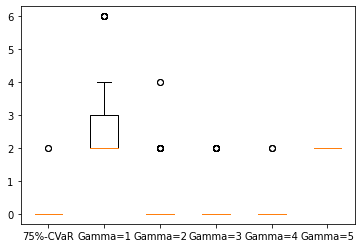

In [37]:
size=400
size_=2000
loc=1
scale=0.5
inst=[5,4,[2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
np.random.seed(0)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,loc,scale,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,loc,scale,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散2

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 84442 rows, 6541 columns and 763290 nonzeros
Model fingerprint: 0xf2ffee4f
Variable types: 6401 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 39879 rows and 3024 columns (presolve time = 5s) ...
Presolve removed 39879 rows and 3024 columns
Presolve time: 6.95s
Presolved: 44563 rows, 3517 columns, 402867 nonzeros
Variable types: 3377 continuous, 140 integer (140 binary)
Found heuristic solution: objective 7.2900000
Found heuristic solution: objective 4.0000000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          9s
     517   -0.0000000e+00   0.000000e+00   0.000000e+00      9s
 

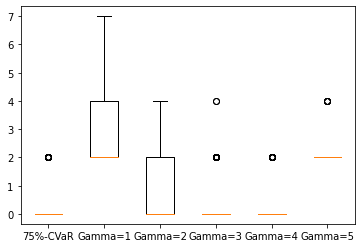

In [38]:
size=400
size_=2000
loc=2
scale=0.5
inst=[5,4,[2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
np.random.seed(0)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,loc,scale,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,loc,scale,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散3

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 84442 rows, 6541 columns and 763290 nonzeros
Model fingerprint: 0xfdc3497f
Variable types: 6401 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 32494 rows and 2464 columns (presolve time = 5s) ...
Presolve removed 32494 rows and 2464 columns
Presolve time: 5.17s
Presolved: 51948 rows, 4077 columns, 469612 nonzeros
Variable types: 3937 continuous, 140 integer (140 binary)
Found heuristic solution: objective 7.3700000
Found heuristic solution: objective 4.0000000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          7s
     783   -0.0000000e+00   0.000000e+00   0.000000e+00      7s
 

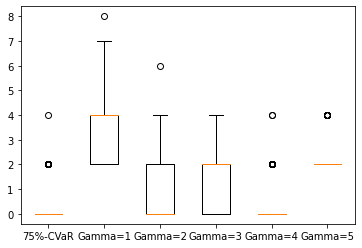

In [39]:
size=400
size_=2000
loc=3
scale=0.5
inst=[5,4,[2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
np.random.seed(0)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,loc,scale,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,loc,scale,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

#### 分散4

In [47]:
size=800
size_=2000
loc=4
scale=0.5
inst=[5,4,[2,2,2,2,2,2,2]]
pcvar=[]
ship_num=len(inst[2])
import numpy as np
mean=np.arange(1,ship_num+1)
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
np.random.seed(0)
cov=np.zeros((ship_num,ship_num))
for i in range(ship_num):
    for j in range(ship_num):
        if i==j:
            cov[i][i]=abs(np.random.normal(loc=loc,scale=scale))
for i in range(ship_num):
    for j in range(ship_num):
        if i!=j:
            cov[i][j]=0

IPS6(ship_num,inst[0],inst[1],inst[2],size,size_,0.75,loc,scale,mean,cov)
pcvar+=list(penalty)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size,size_,loc,scale,mean,cov)
  prob+=list(penalty_r)
  print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 168842 rows, 12941 columns and 1526090 nonzeros
Model fingerprint: 0x48b3a53d
Variable types: 12801 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 74483 rows and 5648 columns (presolve time = 10s) ...
Presolve removed 74483 rows and 5648 columns
Presolve time: 13.78s
Presolved: 94359 rows, 7293 columns, 852919 nonzeros
Variable types: 7153 continuous, 140 integer (140 binary)
Found heuristic solution: objective 7.4600000
Found heuristic solution: objective 4.0000000

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                         